In [1]:
from IPython.display import Image


## Purpose :
#### Predict NYC Taxi trip duration in `RMSLE` metric ( Root Mean Squared Logarithmic Error) 

- https://www.kaggle.com/c/nyc-taxi-trip-duration#evaluation



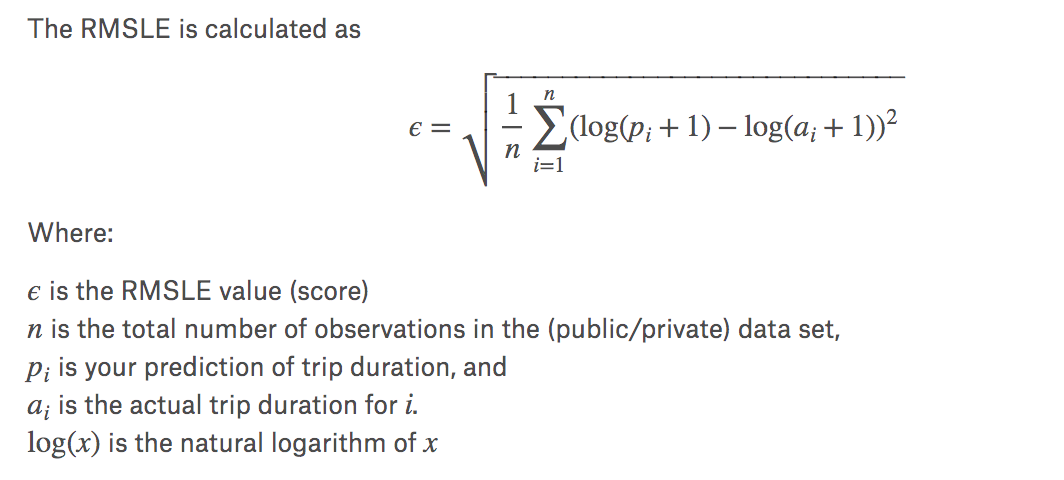

In [2]:
Image(filename='../NYC_Taxi_Trip_Duration/documents/RMSLE.png') 


## Process : 
    - 0 FEATURE ENGINEERING 
    - 0'DATA CLEANING 
    - 1 SIMPLE MODELING 
        -A. Linear 
            -1.1 linear regression
            -1.2 lasso regression
            -1.3 ridge regression
        -B. Non-linear
            -1.4 decision tree regression
            -1.5 random forest regression 
            -1.6 xgboost
    - 2 SELECT MODELS 
        -2.1 feature select 
        -2.2 parameter select 
        -2.2 model tuning
    - 3 PREDICTION ENSEMBLE 
    - 4 FINTAL CHECK
        -4.1 distribution of test predict and train real values

In [3]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
import calendar

Populating the interactive namespace from numpy and matplotlib


In [4]:
# load data

df_train = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/train.csv')
df_test = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/test.csv')
sampleSubmission = pd.read_csv('~/NYC_Taxi_Trip_Duration/data/sample_submission.csv')

## 0) Feature engineering 

In [7]:
# feature engineering 

from sklearn.cluster import MiniBatchKMeans



def get_time_feature(df):
    df_= df.copy()
    # pickup
    df_["pickup_date"] = pd.to_datetime(df_.pickup_datetime.apply(lambda x : x.split(" ")[0]))
    df_["pickup_hour"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
    df_["pickup_year"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
    df_["pickup_month"] = df_.pickup_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
    df_["pickup_weekday"] = df_.pickup_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    # weekday
    list(calendar.day_name)
    df_['pickup_week_'] = pd.to_datetime(df_.pickup_datetime).dt.weekday
    df_['pickup_weekday_'] = df_['pickup_week_'].apply(lambda x: calendar.day_name[x])
    # dropoff
    # in case test data dont have dropoff_datetime feature
    try:
        df_["dropoff_date"] = pd.to_datetime(df_.dropoff_datetime.apply(lambda x : x.split(" ")[0]))
        df_["dropoff_hour"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[1].split(":")[0])
        df_["dropoff_year"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[0])
        df_["dropoff_month"] = df_.dropoff_datetime.apply(lambda x : x.split(" ")[0].split("-")[1])
        df_["dropoff_weekday"] = df_.dropoff_datetime.apply(lambda x :pd.to_datetime(x.split(" ")[0]).weekday())
    except:
        pass 
    return df_

# get time delta gap  
def get_time_feature2(df):
    df_ = df.copy()
    df_['pickup_datetime'] = pd.to_datetime(df_['pickup_datetime'])
    df_['pickup_minute'] = df_['pickup_datetime'].dt.minute
    df_['pickup_time_delta'] = (df_['pickup_datetime'] - df_['pickup_datetime'].min()).dt.total_seconds()
    df_['week_delta'] = df_['pickup_datetime'].dt.weekday + \
                        ((df_['pickup_datetime'].dt.hour + \
                        (df_['pickup_datetime'].dt.minute / 60.0)) / 24.0)
    df_['weekofyear'] = df_['pickup_datetime'].dt.weekofyear
    return df_



# make weekday and hour cyclic, since we want to let machine understand 
# these features are in fact periodically 
def get_time_cyclic(df):
    df_ = df.copy()
    df_.pickup_hour = df_.pickup_hour.astype('int')
    df_['week_delta_sin'] = np.sin((df_['week_delta'] / 7) * np.pi)**2
    df_['pickup_hour_sin'] = np.sin((df_['pickup_hour'] / 24) * np.pi)**2
    return df_


# Haversine distance
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

# Manhattan distance
# Taxi cant fly ! have to move in blocks/roads
def get_manhattan_distance(lat1, lng1, lat2, lng2):
    # km 
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


# get direction (arc tangent angle)
def get_direction(lat1, lng1, lat2, lng2):
    # theta
    AVG_EARTH_RADIUS = 6371  #  km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


def gat_trip_center(df):
    df_ = df.copy()
    df_.loc[:, 'center_latitude'] = (df_['pickup_latitude'].values + df_['dropoff_latitude'].values) / 2
    df_.loc[:, 'center_longitude'] = (df_['pickup_longitude'].values + df_['dropoff_longitude'].values) / 2
    return df_



# PCA to transform longitude and latitude
# to improve decision tree performance 
from sklearn.decomposition import PCA
def pca_lon_lat(dftrain,dftest):
    X = np.vstack \
            ((dftrain[['pickup_latitude', 'pickup_longitude']].values,
              dftrain[['dropoff_latitude', 'dropoff_longitude']].values,
              dftest[['pickup_latitude', 'pickup_longitude']].values,
              dftest[['dropoff_latitude', 'dropoff_longitude']].values))
    # remove potential lon & lat outliers 
    min_lat, min_lng = X.mean(axis=0) - X.std(axis=0)
    max_lat, max_lng = X.mean(axis=0) + X.std(axis=0)
    X = X[(X[:,0] > min_lat) & (X[:,0] < max_lat) & (X[:,1] > min_lng) & (X[:,1] < max_lng)]
    pca = PCA().fit(X)
    dftrain['pickup_pca0'] = pca.transform(dftrain[['pickup_latitude', 'pickup_longitude']])[:, 0]
    dftrain['pickup_pca1'] = pca.transform(dftrain[['pickup_latitude', 'pickup_longitude']])[:, 1]
    dftrain['dropoff_pca0'] = pca.transform(dftrain[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    dftrain['dropoff_pca1'] = pca.transform(dftrain[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    dftest['pickup_pca0'] = pca.transform(dftest[['pickup_latitude', 'pickup_longitude']])[:, 0]
    dftest['pickup_pca1'] = pca.transform(dftest[['pickup_latitude', 'pickup_longitude']])[:, 1]
    dftest['dropoff_pca0'] = pca.transform(dftest[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    dftest['dropoff_pca1'] = pca.transform(dftest[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    # manhattan distance from pca lon & lat 
    dftrain.loc[:, 'pca_manhattan'] = np.abs(dftrain['dropoff_pca1'] - dftrain['pickup_pca1']) + np.abs(dftrain['dropoff_pca0'] - dftrain['pickup_pca0'])
    dftest.loc[:, 'pca_manhattan'] = np.abs(dftest['dropoff_pca1'] - dftest['pickup_pca1']) + np.abs(dftest['dropoff_pca0'] - dftest['pickup_pca0'])
    return dftrain,dftest 


# get lon & lat clustering for following avg location speed calculation
def get_clustering(df):
    coords = np.vstack((df_train[['pickup_latitude', 'pickup_longitude']].values,
                    df_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    df_test[['pickup_latitude', 'pickup_longitude']].values,
                    df_test[['dropoff_latitude', 'dropoff_longitude']].values))
    df_ = df.copy()
    sample_ind = np.random.permutation(len(coords))[:500000]
    kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
    df_.loc[:, 'pickup_cluster'] = kmeans.predict(df_[['pickup_latitude', 'pickup_longitude']])
    df_.loc[:, 'dropoff_cluster'] = kmeans.predict(df_[['dropoff_latitude', 'dropoff_longitude']])
    return df_


def trip_cluser_count(df):
    df_ = df.copy()
    df_.pickup_datetime = pd.to_datetime(df_.pickup_datetime)
    group_freq = '60min'
    df_dropoff_counts = df_ \
        .set_index('pickup_datetime') \
        .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
        .agg({'id': 'count'}) \
        .reset_index().set_index('pickup_datetime') \
        .groupby('dropoff_cluster').rolling('240min').mean() \
        .drop('dropoff_cluster', axis=1) \
        .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
        .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})
        
    df_['pickup_datetime_group'] = df_['pickup_datetime'].dt.round(group_freq)
    df_['dropoff_cluster_count'] = \
            df_[['pickup_datetime_group', 'dropoff_cluster']]\
            .merge(df_dropoff_counts,on=['pickup_datetime_group', 'dropoff_cluster'], how='left')\
            ['dropoff_cluster_count'].fillna(0)
            
    return df_



# avg speed on cluster 
def avg_cluser_speed(df):
    df_ = df.copy()
    # avg speed on cluster 
    avg_cluser_h = df_.groupby(['pickup_cluster','dropoff_cluster']).mean()['avg_speed_h'].reset_index()
    avg_cluser_h.columns = ['pickup_cluster','dropoff_cluster','avg_speed_cluster_h']
    avg_cluser_m = df_.groupby(['pickup_cluster','dropoff_cluster']).mean()['avg_speed_m'].reset_index()
    avg_cluser_m.columns = ['pickup_cluster','dropoff_cluster','avg_speed_cluster_m']
    # merge dataframe
    df_ = pd.merge(df_,avg_cluser_h, how = 'left', on = ['pickup_cluster','dropoff_cluster'])
    df_ = pd.merge(df_,avg_cluser_m, how = 'left', on = ['pickup_cluster','dropoff_cluster'])
    return df_


# avg duration on cluster 
def avg_cluser_duration(df):
    df_ = df.copy()
    # avg speed on cluster 
    avg_cluser_duration = df_.groupby(['pickup_cluster','dropoff_cluster']).mean()['trip_duration'].reset_index()
    avg_cluser_duration.columns = ['pickup_cluster','dropoff_cluster','avg_cluster_duration']
    # merge dataframe
    df_ = pd.merge(df_,avg_cluser_duration, how = 'left', on = ['pickup_cluster','dropoff_cluster'])
    return df_


def avg_cluster_speed_(df):
    df_ = df.copy()
    # only get pickup_cluster first as test here 
    for gby_col in ['pickup_cluster']:
        gby = df_.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'trip_duration']]
        gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
        df_ = pd.merge(df_, gby, how='left', left_on=gby_col, right_index=True)
        #df_test = pd.merge(df_test, gby, how='left', left_on=gby_col, right_index=True)
    for gby_cols in [
                 ['pickup_cluster', 'dropoff_cluster']]:
        coord_speed = df_.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
        coord_count = df_.groupby(gby_cols).count()[['id']].reset_index()
        coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
        #coord_stats = coord_stats[coord_stats['id'] > 100]
        coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
        df_ = pd.merge(df_, coord_stats, how='left', on=gby_cols)
    return df_


def label_2_binary(df):
    df_ = df.copy()
    df_['store_and_fwd_flag_'] = df_['store_and_fwd_flag'].map(lambda x: 0 if x =='N' else 1)
    return df_


### ======================== ###

def get_features(df):
    # km 
    df_ = df.copy()
    ###  USING .loc making return array ordering 
    # distance
    df_.loc[:, 'distance_haversine'] = get_haversine_distance(
                                      df_['pickup_latitude'].values,
                                      df_['pickup_longitude'].values,
                                      df_['dropoff_latitude'].values,
                                      df_['dropoff_longitude'].values)
    df_.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                                      df_['pickup_latitude'].values,
                                      df_['pickup_longitude'].values,
                                      df_['dropoff_latitude'].values,
                                      df_['dropoff_longitude'].values)
    # direction 
    df_.loc[:, 'direction'] = get_direction(df_['pickup_latitude'].values,
                                          df_['pickup_longitude'].values, 
                                          df_['dropoff_latitude'].values, 
                                          df_['dropoff_longitude'].values)
    # Get Average driving speed 
    # km/hr
    # (km/sec = 3600 * (km/hr))
    # in case trip duration is not available in test dataset 
    try:
        df_.loc[:, 'avg_speed_h'] = 3600 * df_['distance_haversine'] / df_['trip_duration']
        df_.loc[:, 'avg_speed_m'] = 3600 * df_['distance_manhattan'] / df_['trip_duration']
    except:
        pass
    
    return df_



In [8]:
#get basic features 
df_train_ = get_time_feature(df_train)
df_test_ = get_time_feature(df_test)


In [9]:
# get remain features 
df_train_ = get_time_feature2(df_train_)
df_test_ = get_time_feature2(df_test_)
df_train_ = get_time_cyclic(df_train_)
df_test_ = get_time_cyclic(df_test_)
# get other features 
df_train_ = get_features(df_train_)
df_test_ = get_features(df_test_)
df_train_,df_test_ = pca_lon_lat(df_train_,df_test_)
# get center of trip route 
df_train_ = gat_trip_center(df_train_)
df_test_ = gat_trip_center(df_test_)
# get lon & lat clustering 
df_train_= get_clustering(df_train_)
df_test_= get_clustering(df_test_)
# get avg ride count on dropoff cluster 
df_train_ = trip_cluser_count(df_train_)
df_test_ = trip_cluser_count(df_test_)
# label -> 0,1 
df_train_ = label_2_binary(df_train_)
df_test_ = label_2_binary(df_test_)
# get avg cluster speed 
df_train_  = avg_cluser_speed(df_train_)
df_train_  = avg_cluser_duration(df_train_)
#df_test_  = avg_cluser_speed(df_test_)
#df_test_  = avg_cluser_duration(df_test_)
# get log trip duration 
df_train_['trip_duration_log'] = df_train_['trip_duration'].apply(np.log)


In [10]:
df_train_.head(1)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,center_longitude,pickup_cluster,dropoff_cluster,pickup_datetime_group,dropoff_cluster_count,store_and_fwd_flag_,avg_speed_cluster_h,avg_speed_cluster_m,avg_cluster_duration,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,N,...,-73.973392,99,40,2016-03-14 17:00:00,11.75,0,9.282924,11.443996,617.548688,6.120297


In [11]:
#df_train_.columns

## 0') Data cleaning 

In [12]:
# data cleaning

def clean_data(df):
    df_ = df.copy()
    # remove potential distance outlier 
    df_ = df_[(df_['distance_haversine'] < df_['distance_haversine'].quantile(0.95))&
         (df_['distance_haversine'] > df_['distance_haversine'].quantile(0.05))]
    df_ = df_[(df_['distance_manhattan'] < df_['distance_manhattan'].quantile(0.95))&
         (df_['distance_manhattan'] > df_['distance_manhattan'].quantile(0.05))]
    # remove potential  trip duration outlier 
    # trip duration should less then 0.5 day and > 10 sec normally
    # in case test data has no trip duration 
    try:
        df_ = df_[(df_['trip_duration']  < 3*3600) & (df_['trip_duration'] > 10)]
        df_ = df_[(df_['trip_duration'] < df_['trip_duration'].quantile(0.95))&
             (df_['trip_duration'] > df_['trip_duration'].quantile(0.05))]
    # remove potential speed outlier  
        df_ = df_[(df_['avg_speed_h']  < 100) & (df_['avg_speed_h'] > 0)]
        df_ = df_[(df_['avg_speed_m']  < 100) & (df_['avg_speed_m'] > 0)]
        df_ = df_[(df_['avg_speed_h'] < df_['avg_speed_h'].quantile(0.95))&
         (df_['avg_speed_h'] > df_['avg_speed_h'].quantile(0.05))]
        df_ = df_[(df_['avg_speed_m'] < df_['avg_speed_m'].quantile(0.95))&
         (df_['avg_speed_m'] > df_['avg_speed_m'].quantile(0.05))]
    # remove the 2016-01-23 data since its too less comapre others days, 
    # maybe quality is not good 
        df_ = df_[(df_.pickup_date != '2016-01-23') &
                 (df_.dropoff_date != '2016-01-23')]
    except:
        pass
 
    # potential passenger_count outlier 
    df_ = df_[(df_['passenger_count']  <= 6) & (df_['passenger_count'] > 0)]
    
    return df_






## 1) Simple modeling 

In [124]:
#  modeling help function 

from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import learning_curve
from sklearn import pipeline



def sample_split(df):
    #data =  data[selected_feature]
    relevent_cols = list(df)
    data=df.values.astype(float)             
    Y = data[:,0]
    X = data[:,1:]
    test_size = .3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
    return X_train, X_test, y_train, y_test,X,Y


def reg_analysis(model, df):
    # get train, test set amd X,y here (for cross-validation) 
    X_train, X_test, y_train, y_test,X,Y = sample_split(df)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    # Cross-validation score
    cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)
    print ('cv model score = ',cross_val_score(model, X, Y, cv=cv))
    # Model score
    print ('Model score = ',model.score(X_test,y_test))
    # Mean squared log error
    # https://www.kaggle.com/wiki/RootMeanSquaredError
    #print ('Mean squared log error = ', mean_squared_error(prediction, y_test))
    # RMSLE score
    sum=0.0
    for x in range(len(prediction)):
        p = np.log(prediction[x]+1)
        r = np.log(y_test[x]+1)
        sum = sum + (p - r)**2
    print ('RMSLE score =  ',(sum/len(prediction))**0.5)
    return model
    

def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5


def learn_curve(X,y,model):
        #df_train_2 = df_train_.head(10000)
        print ('model : ',model)
        # get train, test scores
        train_sizes, train_scores, test_scores = learning_curve(
                                                 model, X=X, y=y, 
                                                 cv=10, n_jobs=1, 
                                                 train_sizes=np.linspace(0.1,1,10))

        print ('train_sizes = ', train_sizes)
        #print ('train_scores = ', train_scores)
        #print ('test_scores = ', test_scores)
        # get mean, std 
        train_mean = np.mean(train_scores,axis = 1 )
        train_std = np.std(train_scores,axis = 1 )
        test_mean = np.mean(test_scores,axis = 1 )
        test_std = np.std(test_scores,axis = 1 )

        # plot 
        plt.plot(train_sizes,
                 train_mean,
                 color='blue', 
                 marker='o',
                 markersize=5,
                 label="training accuracy")
        # plot errors 
        plt.fill_between(train_sizes, 
                         train_mean + train_std , 
                         train_mean - train_std , 
                         alpha = 0.15,
                         color = 'blue',
                         label="training accuracy")


        plt.plot(train_sizes,
                 test_mean,
                 color='green',
                 linestyle='--' ,
                 marker='s',
                 markersize=5,
                 label="validation accuracy")

        plt.fill_between(train_sizes, 
                         test_mean + test_std , 
                         test_mean -  test_std , 
                         alpha = 0.15,
                         color = 'green',
                         label="validation accuracy")
        plt.grid()
        plt.xlabel('# of train sample')
        plt.ylabel('Accuracy')
        plt.legend(loc = "lower right")
        plt.ylim([0.1,1.2])
        plt.grid()
        plt.show()



//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 22:06:07.212763. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### 1-1) linear regression

In [16]:
df_train_linear_ = clean_data(df_train_)
X_linear = df_train_linear_[['distance_haversine', 'distance_manhattan']]
y_linear = df_train_linear_[['trip_duration']]

In [17]:
from sklearn import linear_model
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

linear_model = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(linear_model, X_linear, y_linear, cv=cv)

//anaconda/envs/g_dash/lib/python3.4/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


array([ 0.65697989,  0.6574361 ,  0.6573305 ,  0.65803125,  0.65590603])

In [18]:
# train, test seperate 
# 70% train, 30% test 
#X_train, X_test, y_train, y_test,X,Y = sample_split(df_train_linear_[linear_feature])

### 1-2) lasso regression

In [19]:
df_train_lasso_ = clean_data(df_train_)
X_lasso = df_train_lasso_[['distance_haversine', 'distance_manhattan']]
y_lasso = df_train_lasso_[['trip_duration']]

In [20]:
from sklearn import linear_model
lasso_model = linear_model.Ridge (alpha = .5)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(lasso_model, X_lasso, y_lasso, cv=cv)

array([ 0.65697989,  0.6574361 ,  0.6573305 ,  0.65803125,  0.65590603])

### 1-3) ridge regression

In [21]:
df_train_ridge_ = clean_data(df_train_)
X_ridge = df_train_ridge_[['distance_haversine', 'distance_manhattan']]
y_ridge = df_train_ridge_[['trip_duration']]

In [22]:
ridge_model = linear_model.Ridge (alpha = .01)
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(ridge_model, X_ridge, y_ridge, cv=cv)   

array([ 0.65697989,  0.6574361 ,  0.6573305 ,  0.65803125,  0.65590603])

### 1-4) decision tree regression

In [23]:
#df_train_.columns

In [24]:
df_train_tree_ = clean_data(df_train_)

In [25]:
tree_feature = ['trip_duration', 'vendor_id', 
                'passenger_count','pickup_pca0', 
                'pickup_pca1','dropoff_pca0',''
                'dropoff_pca1','pickup_hour','pickup_month',
                'dropoff_hour','dropoff_month','direction',
                'distance_haversine','pickup_weekday',
                'distance_manhattan']

In [26]:
# before adding avg_speed_h, but add PCA lon & lat 
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model = reg_analysis(tree_model,df_train_tree_[tree_feature])

cv model score =  [ 0.60731277  0.60842405  0.61031645  0.61103132]
Model score =  0.611266853809
RMSLE score =   0.294463596784


In [27]:
# after adding avg_speed_h
#from sklearn.tree import DecisionTreeRegressor
#tree_model = DecisionTreeRegressor()
#tree_model = reg_analysis(tree_model,df_train_tree_[tree_feature])

### 1-5) random forest regression 

In [28]:
#df_train_.columns

In [29]:
# random sample sub data set for fast train
df_train_rf_ = clean_data(df_train_.sample(50000))

In [30]:
rf_feature =['trip_duration_log',
            'vendor_id',
           'passenger_count',
           'store_and_fwd_flag_',
           'pickup_latitude',
           'pickup_longitude',
           'dropoff_latitude',
           'dropoff_longitude',
           'center_latitude',
           'center_longitude',
           'pickup_pca0',
           'pickup_pca1',
           'dropoff_pca0',
           'dropoff_pca1',
           'distance_haversine',
           'direction',
           'distance_manhattan',
           'pickup_minute',
           'pickup_hour',
           'pickup_weekday',
           'pickup_month',
           'week_delta',
           'weekofyear',
           'week_delta_sin',
           'pickup_hour_sin',
           'pickup_time_delta',
           'dropoff_cluster_count',
           'avg_speed_cluster_h',
           'avg_cluster_duration']

In [31]:
# before adding avg_speed_h, but add PCA lon & lat 
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
reg_analysis(rf_model,df_train_rf_[rf_feature])

cv model score =  [ 0.76778992  0.76241188  0.7616808   0.76012403]
Model score =  0.762891987698
RMSLE score =   0.0319305046958


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [108]:
# before adding avg_speed_h, but add PCA lon & lat 
#from sklearn.ensemble import RandomForestRegressor
#rf_model = RandomForestRegressor()
#reg_analysis(rf_model,df_train_rf_[rf_feature])


//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 20:35:48.751598. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


#### After  re-train models with New features : `avg_speed_h`, `avg_speed_m` ..
 We found out the RMSLE score is `significantly better` than before,
 since `Trip Duration ≈ Distance/avg_speed`; However, dropoff time is `not available` in `test dataset`, so we will use `loaction clustering` method to get avg_speed in clusters approach
 this. 
 

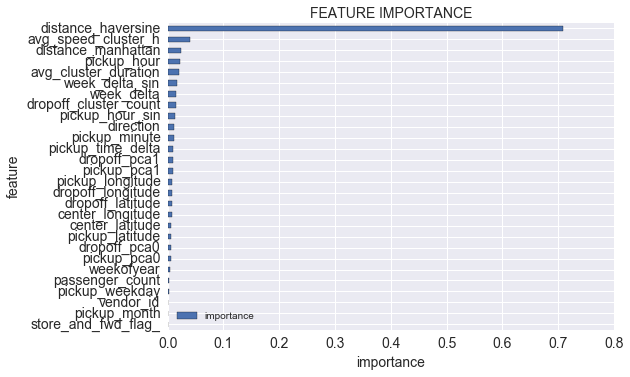

In [42]:
# plot feature importance 

pd.DataFrame({'feature': rf_feature[1:], \
              'importance': rf_model.feature_importances_})\
              .sort_values('importance')\
              .set_index('feature')\
              .plot(kind='barh', fontsize=14)

plt.title('FEATURE IMPORTANCE',fontsize=14 )
plt.xlabel('importance',fontsize=14)
plt.ylabel('feature',fontsize=14)


model :  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
train_sizes =  [ 900 1800 2700 3600 4500 5400 6300 7200 8100 9000]


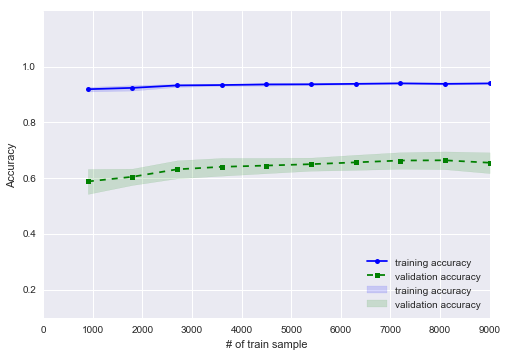

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 22:06:16.934970. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [125]:
# learning curve 

X = df_train_.head(10000)[rf_feature[1:]]
y = df_train_.head(10000)['trip_duration_log']

learn_curve(X,y,rf_model)

### 1-6) xgboost

In [83]:
import xgboost as xgb

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 19:54:01.406757. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [44]:
df_train_xgb_ = clean_data(df_train_.sample(50000))

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 18:00:13.020506. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [130]:
xgb_feature =['trip_duration_log',
            'vendor_id',
           'passenger_count',
           'store_and_fwd_flag_',
           'pickup_latitude',
           'pickup_longitude',
           'dropoff_latitude',
           'dropoff_longitude',
           'center_latitude',
           'center_longitude',
           'pickup_pca0',
           'pickup_pca1',
           'dropoff_pca0',
           'dropoff_pca1',
           'distance_haversine',
           'direction',
           'distance_manhattan',
           'pickup_minute',
           'pickup_hour',
           'pickup_weekday',
           #'pickup_month',
           'week_delta',
           'weekofyear',
           'week_delta_sin',
           'pickup_hour_sin',
           'pickup_time_delta']
           #'dropoff_cluster_count',
           #'avg_speed_cluster_h',
           #'avg_cluster_duration']

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 22:15:02.473564. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [46]:
xgboost_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
reg_analysis(xgboost_model,df_train_xgb_[xgb_feature])

//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nth

cv model score =  [ 0.80935118  0.80504984  0.80588984  0.80472257]
Model score =  0.808180813647
RMSLE score =   0.0285615890955


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.75)

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 18:00:16.348192. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


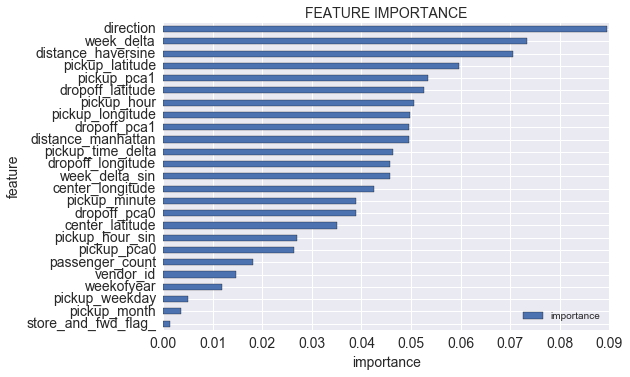

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 18:09:02.250412. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [54]:
# plot feature importance 

pd.DataFrame({'feature': xgb_feature[1:], \
              'importance': xgboost_model.feature_importances_})\
              .sort_values('importance').set_index('feature')\
              .plot(kind='barh', fontsize=14)


plt.title('FEATURE IMPORTANCE',fontsize=14 )
plt.xlabel('importance',fontsize=14)
plt.ylabel('feature',fontsize=14)


model :  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.75)


//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nth

//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nth

//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nth

//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)
//anaconda/envs/g_dash/lib/python3.4/site-packages/xgboost-0.6-py3.4.egg/xgboost/sklearn.py:171: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nth

train_sizes =  [ 900 1800 2700 3600 4500 5400 6300 7200 8100 9000]


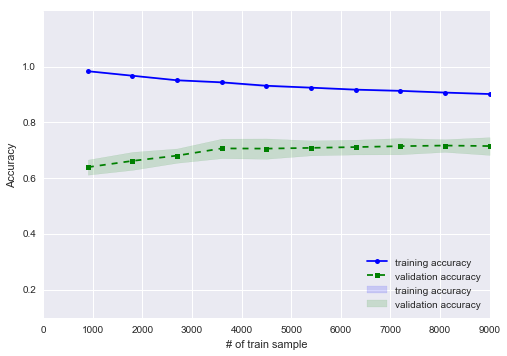

//anaconda/envs/g_dash/lib/python3.4/site-packages/simplejson/encoder.py:275: DeprecationWarning: Interpreting naive datetime as local 2017-08-15 22:15:06.532501. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [131]:
# learning curve 

X = df_train_.head(10000)[xgb_feature[1:]]
y = df_train_.head(10000)['trip_duration_log']

learn_curve(X,y,xgboost_model)
